<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Create-the-dataset" data-toc-modified-id="Create-the-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create the dataset</a></span></li><li><span><a href="#Create-neural-network" data-toc-modified-id="Create-neural-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create neural network</a></span><ul class="toc-item"><li><span><a href="#Now-with-constraints" data-toc-modified-id="Now-with-constraints-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Now with constraints</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create the dataset

In [2]:
z = np.linspace(0, 1, 20)
z_plot = np.linspace(0, 1, 21)

In [3]:
def get_y(x1, x2, x3):
    x1 = np.atleast_1d(x1); x2 = np.atleast_1d(x2); x3 = np.atleast_1d(x3)
    tmp =  (x1.reshape(x1.shape[0], 1) * np.sin(1 * np.pi * z.reshape(1, 20)) + 
            x2.reshape(x1.shape[0], 1) * np.sin(4 * np.pi * z.reshape(1, 20)) + 
            x3.reshape(x1.shape[0], 1) * np.sin(5 * np.pi * z.reshape(1, 20)))
    tmp = (tmp.T - np.mean(tmp, axis=1)).T
    rain = np.maximum(0, np.sum(tmp[:, 10:], axis=1).reshape((-1, 1))) * 10
    tmp[:, 10:] =  tmp[:, 10:] - (rain / 10.)
    return np.concatenate([tmp, rain], axis=1)

In [4]:
# create sample data
n_samples = 10000
x1 = np.random.normal(size=n_samples)
x2 = np.random.normal(size=n_samples)
x3 = np.random.normal(size=n_samples)
y = get_y(x1, x2, x3)

In [5]:
y.shape

(10000, 21)

(1.1657341758564144e-15, 0.0)

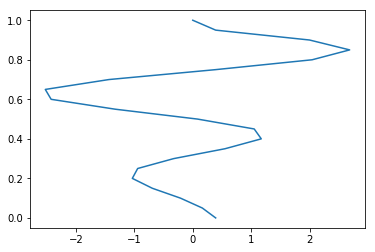

In [6]:
i = np.random.randint(0, n_samples)
plt.plot(y[i], z_plot);
np.sum(y[i]), y[i, -1]

(array([ 6394.,  1113.,   975.,   615.,   456.,   250.,   112.,    55.,
           23.,     7.]),
 array([ 0.        ,  0.28586053,  0.57172106,  0.85758159,  1.14344212,
         1.42930265,  1.71516318,  2.00102371,  2.28688424,  2.57274477,
         2.85860529]),
 <a list of 10 Patch objects>)

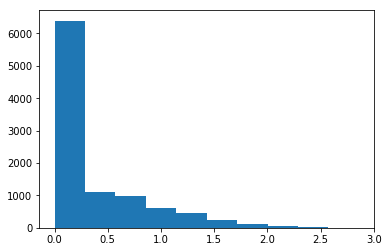

In [7]:
plt.hist(y[:, -1])

In [8]:
# Create test and valid data
x = np.stack([x1, x2, x3], axis=1)
# Add noise to xs
x += (np.random.rand(x.shape[0], x.shape[1]) - 0.2) * 0.6

In [9]:
i_split = int(0.8*n_samples)

In [10]:
x_train = x[:i_split]
y_train = y[:i_split]
x_valid = x[i_split:]
y_valid = y[i_split:]

## Create neural network 

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [12]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [13]:
model = Sequential([
    Dense(200, input_shape=(3,), activation='relu'),
    Dense(200, activation='relu'),
    Dense(21)
])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 21)                4221      
Total params: 45,221
Trainable params: 45,221
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(Adam(0.001), 'mse')

In [16]:
model.fit(x_train, y_train, batch_size=512, epochs=10, validation_data=(x_valid, y_valid))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 4s - loss: 0.7219 - val_loss: 0.3580
Epoch 2/10
8000/8000 [==============================] - 0s - loss: 0.1497 - val_loss: 0.0615
Epoch 3/10
8000/8000 [==============================] - 0s - loss: 0.0540 - val_loss: 0.0407
Epoch 4/10
8000/8000 [==============================] - 0s - loss: 0.0374 - val_loss: 0.0351
Epoch 5/10
8000/8000 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0327
Epoch 6/10
8000/8000 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0318
Epoch 7/10
8000/8000 [==============================] - 0s - loss: 0.0313 - val_loss: 0.0313
Epoch 8/10
8000/8000 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0309
Epoch 9/10
8000/8000 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0306
Epoch 10/10
8000/8000 [==============================] - 0s - loss: 0.0304 - val_loss: 0.0306


In [17]:
y_pred = model.predict(x_valid)

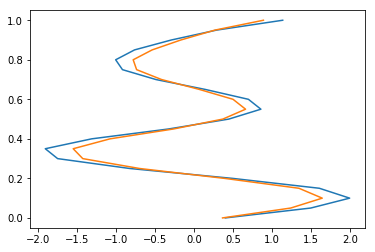

In [18]:
i = np.random.randint(0, n_samples*0.2)
plt.plot(y_valid[i], z_plot, label='true')
plt.plot(y_pred[i], z_plot, label='pred')

In [19]:
np.mean(np.abs(np.mean(y_pred[:, :], axis=1))), np.mean(np.abs(np.mean(y_valid[:], axis=1)))

(0.0038725466, 5.6752624673163581e-17)

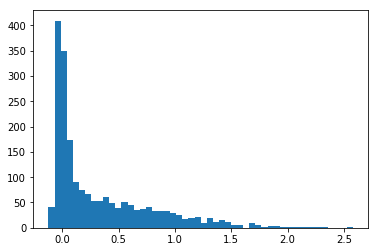

In [22]:
plt.hist(y_pred[:, -1], bins=50);

### Now with constraints

In [64]:
import keras.backend as K
def transform(x):
    """x[sample, z-1]"""
    x_rain = K.reshape(K.maximum(0., x[:, -1]), (-1, 1))
    x_first = - K.reshape(K.sum(x[:, :-1], axis=1), (-1, 1)) - x_rain
    return K.concatenate([x_first, x[:, :-1], x_rain], axis=1)

In [65]:
from keras.losses import mean_squared_error
def transformed_mse(y_true, y_pred):
    return mean_squared_error(y_true, transform(y_pred))

In [66]:
model_transform = Sequential([
    Dense(200, input_shape=(3,), activation='relu'),
    Dense(200, activation='relu'),
    Dense(21-1)
])

In [67]:
model_transform.compile(Adam(0.001), transformed_mse)

In [68]:
model_transform.fit(x_train, y_train, batch_size=512, epochs=10, 
                    validation_data=(x_valid, y_valid))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 0s - loss: 0.7576 - val_loss: 0.4219
Epoch 2/10
8000/8000 [==============================] - 0s - loss: 0.1971 - val_loss: 0.0633
Epoch 3/10
8000/8000 [==============================] - 0s - loss: 0.0559 - val_loss: 0.0417ss: 0.059
Epoch 4/10
8000/8000 [==============================] - 0s - loss: 0.0384 - val_loss: 0.0350
Epoch 5/10
8000/8000 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0333
Epoch 6/10
8000/8000 [==============================] - 0s - loss: 0.0323 - val_loss: 0.0321
Epoch 7/10
8000/8000 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0317
Epoch 8/10
8000/8000 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0311
Epoch 9/10
8000/8000 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0309
Epoch 10/10
8000/8000 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0307


In [69]:
y_pred_trans = model_transform.predict(x_valid)

y_rain = np.maximum(0, y_pred_trans[:, -1]).reshape((-1, 1))
y_first = -y_pred_trans[:, :-1].sum(axis=1).reshape((-1, 1)) - y_rain

y_pred_trans = np.concatenate([y_first, y_pred_trans[:, :-1], y_rain], axis=1)

(1.4305115e-06, 1.3322676295501878e-15)

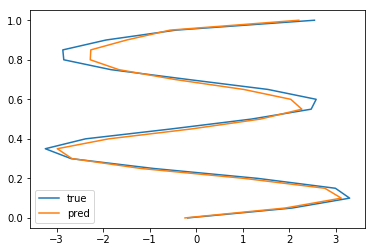

In [127]:
i = np.random.randint(0, 200)
i = 1948
plt.plot(y_valid[i], z_plot, label='true')
plt.plot(y_pred_trans[i], z_plot, label='pred')
plt.legend();
np.sum(y_pred_trans[i]), np.sum(y_valid[i])

In [126]:
max_error = np.argmax(np.mean(np.abs((y_valid - y_pred_trans)), axis=1))
max_error

1948

In [71]:
y_pred_trans.shape

(2000, 21)

In [72]:
np.mean(np.abs(np.mean(y_pred_trans, axis=1))), np.mean(np.abs(np.mean(y_valid, axis=1)))

(1.4690595e-08, 5.6752624673163581e-17)

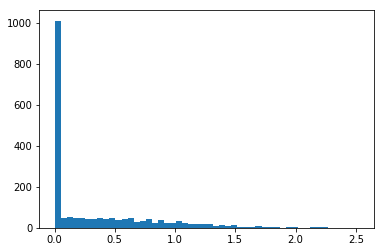

In [73]:
plt.hist(y_pred_trans[:, -1], bins=50);

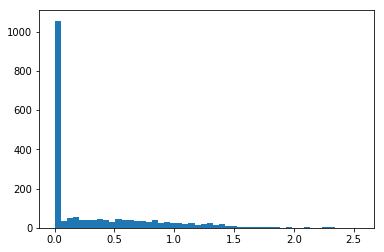

In [74]:
plt.hist(y_valid[:, -1], bins=50);